In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O


# Novozymes Enzyme Stability Prediction Notebook

## In this notebook we:

 1. **Import dependencies & set up the environment:** Load libraries, configure TPU/CPU/GPU, and set random seeds for reproducibility.
 2. **Access and load data:** Read in the training, test, submission CSV files and the wildtype PDB file.
 3. **Data engineering and cleaning:** Create new features (amino acid counts, fractions, sequence lengths), fix any pH swap issues, and map data sources.
 4. **Exploratory Data Analysis (EDA):** Examine distributions of target (`tm`), pH values, amino acid frequencies, and correlations.
 5. **Helper functions:** Define functions to extract mutation information from protein sequences.
 6. **Baseline Modeling with XGBoost:** Train a basic model using engineered features, evaluate with cross-validation, and produce a submission file.
 7. **Additional plots and analysis:** Visualize distributions and correlations to gain further insights.
#
### Let’s begin!

## 1. IMPORT DEPENDENCIES & SETUP

In [2]:
!pip install python-Levenshtein
!pip install -q biopandas
!pip install -q biopython
!pip install -q pandarallel
!pip install -q xgboost
!pip install -q plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.9 MB/s eta 0:00:00


In [3]:
# Basic machine learning & data science libraries
import os, random, gc, sys, time, math, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# TensorFlow and TPU utilities
import tensorflow as tf
try:
    import tensorflow_hub as tfhub
    import tensorflow_addons as tfa
    import tensorflow_io as tfio
except ImportError:
    pass  # These may not be needed if not using deep learning models

# Bioinformatics libraries for handling protein structures
import Levenshtein
from biopandas.pdb import PandasPdb

# Utility for parallel processing in pandas
from pandarallel import pandarallel
pandarallel.initialize()

# XGBoost for baseline modeling
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# For Kaggle dataset access (if running on Kaggle)
try:
    from kaggle_datasets import KaggleDatasets
except ImportError:
    KaggleDatasets = None

# Set random seed for reproducibility
def seed_everything(seed=7):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

print("Imports complete.")

## 2. Accelerator Setup
This block detects if a TPU is available and sets the appropriate TensorFlow strategy. If no TPU is found, we use the default CPU/GPU strategy.


In [ ]:
print("\nSetting up Accelerator...\n")
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    TPU = None

if TPU:
    print(f"Running on TPU: {TPU.master()}")
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    print("Running on CPU/GPU")
    strategy = tf.distribute.get_strategy()
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

print(f"Number of replicas in sync: {strategy.num_replicas_in_sync}")

## 3. DATA ACCESS & LOADING
 Here we set the data directory. On Kaggle we use the KaggleDatasets API to access the Google Cloud Storage (GCS) path; otherwise, we set a local path. Then we load the training, test, sample submission, and the wildtype PDB file.


In [4]:
print("\nLoading Data...\n")

DATA_DIR = "novozymes-enzyme-stability-prediction"  # adjust if running locally

print("Data directory:", DATA_DIR)
print("Files in Data Directory:")
for file in tf.io.gfile.glob(os.path.join(DATA_DIR, "*")):
    print(" -", file)


Loading Data...

Data directory: novozymes-enzyme-stability-prediction
Files in Data Directory:
 - novozymes-enzyme-stability-prediction/test.csv
 - novozymes-enzyme-stability-prediction/train.csv
 - novozymes-enzyme-stability-prediction/sample_submission.csv
 - novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
 - novozymes-enzyme-stability-prediction/train_updates_20220929.csv
 - novozymes-enzyme-stability-prediction/test_labels.csv


In [5]:
# Load CSVs
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
ss_df    = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

# Load the wildtype PDB file using BioPandas
pdb = PandasPdb()
pdb_df = pdb.read_pdb(os.path.join(DATA_DIR, "wildtype_structure_prediction_af2.pdb"))


## 4. DATA ENGINEERING & CLEANING
### We create additional features from the protein sequences:
- **Sequence length (`n_AA`):** Number of amino acids.
- **Amino acid counts & fractions:** For each amino acid (using one-letter codes), we calculate how many times it appears and its fraction relative to sequence length.
- **Data source encoding:** Map the textual data source to an integer.
- **Temporary pH fix:** Some rows have a pH value > 14; we swap these with the `tm` value.

We also define dictionaries mapping amino acids between formats.


In [6]:
print("\nEngineering new features...\n")

# Define mapping for amino acids (long name, 3-letter, and 1-letter codes)
aa_map = {
    "Alanine": ("Ala", "A"), "Arginine": ("Arg", "R"), "Asparagine": ("Asn", "N"),
    "Aspartic_Acid": ("Asp", "D"), "Cysteine": ("Cys", "C"), "Glutamic_Acid": ("Glu", "E"),
    "Glutamine": ("Gln", "Q"), "Glycine": ("Gly", "G"), "Histidine": ("His", "H"),
    "Isoleucine": ("Ile", "I"), "Leucine": ("Leu", "L"), "Lysine": ("Lys", "K"),
    "Methionine": ("Met", "M"), "Phenylalanine": ("Phe", "F"), "Proline": ("Pro", "P"),
    "Serine": ("Ser", "S"), "Threonine": ("Thr", "T"), "Tryptophan": ("Trp", "W"),
    "Tyrosine": ("Tyr", "Y"), "Valine": ("Val", "V")
}
aa_chars_ordered = sorted([v[1] for v in aa_map.values()])  # sort by one-letter code

# Add sequence length to train and test
train_df["n_AA"] = train_df["protein_sequence"].apply(len)
test_df["n_AA"]  = test_df["protein_sequence"].apply(len)

# For each amino acid, count occurrences and compute fraction
for aa in aa_chars_ordered:
    count_col = f"AA_{aa}__count"
    frac_col  = f"AA_{aa}__fraction"
    train_df[count_col] = train_df["protein_sequence"].apply(lambda x: x.count(aa))
    train_df[frac_col]  = train_df[count_col] / train_df["n_AA"]
    test_df[count_col]  = test_df["protein_sequence"].apply(lambda x: x.count(aa))
    test_df[frac_col]   = test_df[count_col] / test_df["n_AA"]

# Encode data_source into an integer for modeling simplicity
ds_str2int = {k: i for i, k in enumerate(train_df["data_source"].dropna().unique())}
train_df["data_source_enum"] = train_df["data_source"].map(ds_str2int)
test_df["data_source_enum"]  = test_df["data_source"].map(ds_str2int)

# Temporary fix for pH: if pH > 14, swap pH and tm (indicates a data error)
def fix_ph(row):
    if row["pH"] > 14:
        # Log the issue and swap values
        # print(f"Swapping pH and tm at index {row.name}")
        row["pH"], row["tm"] = row["tm"], row["pH"]
    return row

train_df = train_df.apply(fix_ph, axis=1)
test_df  = test_df.apply(fix_ph, axis=1)

print("Data engineering complete.\n")
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)


Engineering new features...

Data engineering complete.

Train shape: (31390, 47) Test shape: (2413, 46)


## 5. EXPLORATORY DATA ANALYSIS (EDA)
### In this section we explore:
- The distribution of the target `tm`
- pH value distribution
- Amino acid sequence lengths
- Frequency of data sources
- Correlations between amino acid counts/fractions and the target `tm`
### We also add several plots (using Plotly for interactivity) to better visualize these distributions.


In [7]:
print("\nPerforming Exploratory Data Analysis (EDA)...\n")

# Plot distribution of melting temperatures (tm)
fig_tm = px.histogram(train_df, x="tm", nbins=50,
                        title="Distribution of Melting Temperature (tm)")
fig_tm.show()



Performing Exploratory Data Analysis (EDA)...



In [8]:
# Plot pH distribution
fig_ph = px.histogram(train_df, x="pH", nbins=50,
                        title="Distribution of pH values in training data")
fig_ph.show()


In [9]:
# Plot distribution of protein sequence lengths
fig_len = px.histogram(train_df, x="n_AA", nbins=50, log_y=True,
                       title="Distribution of Protein Sequence Lengths (log scale)")
fig_len.show()

In [10]:
# Check correlations: for each amino acid, print the Spearman correlation of count and fraction with tm
print("Spearman correlations with tm:")
for aa in aa_chars_ordered:
    count_corr = train_df[f"AA_{aa}__count"].corr(train_df["tm"], method='spearman')
    frac_corr  = train_df[f"AA_{aa}__fraction"].corr(train_df["tm"], method='spearman')
    print(f"AA {aa}: count corr = {count_corr:.3f}, fraction corr = {frac_corr:.3f}")


Spearman correlations with tm:
AA A: count corr = -0.006, fraction corr = 0.094
AA C: count corr = -0.123, fraction corr = -0.098
AA D: count corr = -0.089, fraction corr = -0.084
AA E: count corr = -0.029, fraction corr = 0.047
AA F: count corr = -0.073, fraction corr = -0.045
AA G: count corr = 0.011, fraction corr = 0.117
AA H: count corr = -0.058, fraction corr = -0.028
AA I: count corr = -0.085, fraction corr = -0.048
AA K: count corr = -0.156, fraction corr = -0.175
AA L: count corr = -0.004, fraction corr = 0.101
AA M: count corr = -0.097, fraction corr = -0.089
AA N: count corr = -0.132, fraction corr = -0.133
AA P: count corr = 0.007, fraction corr = 0.090
AA Q: count corr = -0.114, fraction corr = -0.109
AA R: count corr = 0.027, fraction corr = 0.143
AA S: count corr = -0.123, fraction corr = -0.156
AA T: count corr = -0.112, fraction corr = -0.157
AA V: count corr = -0.024, fraction corr = 0.066
AA W: count corr = -0.025, fraction corr = 0.014
AA Y: count corr = -0.062, fra

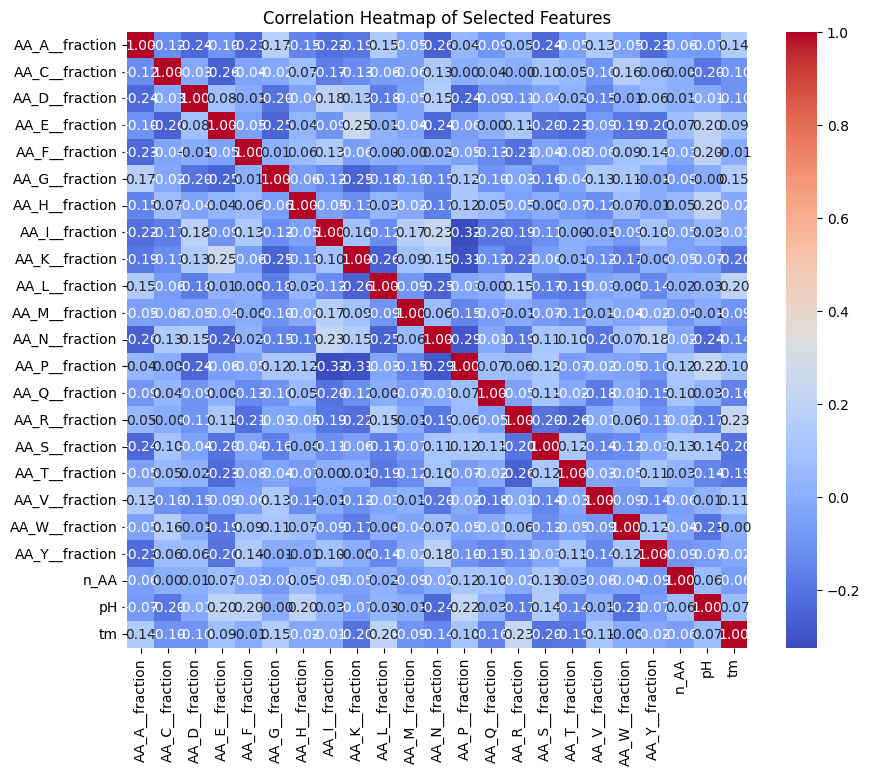

In [11]:
# Create a heatmap of correlations for engineered features (only a sample of columns for clarity)
features = [col for col in train_df.columns if "__fraction" in col] + ["n_AA", "pH", "tm"]
corr = train_df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Selected Features")
plt.show()


## 6. HELPER FUNCTIONS FOR MUTATION ANALYSIS
## For the test data, we need to extract mutation information between the wildtype and the variant protein sequences. We use the Levenshtein distance edit operations to extract:
- **edit_type:** substitution, insertion, or deletion.
- **edit_idx:** the index at which the edit occurs.
- **wildtype_aa / mutant_aa:** the original and mutated amino acids.

We also define helper functions to create text files for mutation calls and a FASTA file for the wildtype sequence.


In [12]:
def get_mutation_info(row, wildtype="VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"):
    # Map the edit type for readability
    terminology_map = {"replace": "substitution", "insert": "insertion", "delete": "deletion"}
    # Compute edit operations
    edits = Levenshtein.editops(wildtype, row["protein_sequence"])
    row["n_edits"] = len(edits)
    if row["n_edits"] == 0:
        row["edit_type"] = pd.NA
        row["edit_idx"] = pd.NA
        row["wildtype_aa"] = pd.NA
        row["mutant_aa"] = pd.NA
    else:
        # We assume a single mutation (the first edit)
        op, i, j = edits[0]
        row["edit_type"] = terminology_map.get(op, op)
        row["edit_idx"] = i  # zero-indexed position in wildtype
        row["wildtype_aa"] = wildtype[i]
        # For deletion, there is no mutant amino acid
        row["mutant_aa"] = row["protein_sequence"][j] if op != "delete" else pd.NA
    return row

In [13]:
def revert_to_wildtype(protein_sequence, edit_type, edit_idx, wildtype_aa, mutant_aa):
    if pd.isna(edit_type):
        return protein_sequence
    if edit_type != "insertion":
        base = protein_sequence[:edit_idx]
        if edit_type == "deletion":
            new_seq = base + wildtype_aa + protein_sequence[edit_idx:]
        else:  # substitution
            new_seq = base + wildtype_aa + protein_sequence[edit_idx+1:]
    else:
        new_seq = protein_sequence[:edit_idx] + wildtype_aa + protein_sequence[edit_idx:]
    return new_seq


In [14]:
def create_mutation_txt_file(test_df, filename="AF70_mutations.txt", include_deletions=False):
    with open(filename, 'w') as f:
        for _, row in test_df.iterrows():
            if pd.isna(row["edit_type"]) or (row["edit_type"]=="deletion" and not include_deletions):
                continue
            # Mutation notation: wildtype letter + 1-indexed position + mutant letter
            mutation = f'{row["wildtype_aa"]}{row["edit_idx"]+1}{"" if pd.isna(row["mutant_aa"]) else row["mutant_aa"]}'
            f.write(mutation + "\n")


In [15]:
def create_wildtype_fasta_file(wildtype_sequence, filename="wildtype_af70.fasta"):
    with open(filename, 'w') as f:
        f.write(f">af70_wildtype\n{wildtype_sequence}")


In [16]:
# Apply mutation info extraction to test dataframe
test_df = test_df.apply(get_mutation_info, axis=1)
print("Mutation info added to test dataframe. Sample:")
display(test_df[["protein_sequence", "edit_type", "edit_idx", "wildtype_aa", "mutant_aa"]].head(10))

# Optionally create mutation and FASTA files
create_mutation_txt_file(test_df)
wildtype_aa = "VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"
create_wildtype_fasta_file(wildtype_aa)


Mutation info added to test dataframe. Sample:


,protein_sequence,edit_type,edit_idx,wildtype_aa,mutant_aa
0,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,substitution,16,L,E
1,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,substitution,16,L,K
2,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,deletion,16,L,<NA>
3,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,substitution,17,K,C
4,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,substitution,17,K,F
5,VPVNPEPDATSVENVALGTGSGDSQSDPIKADLEVKGQSALPFDVD...,substitution,17,K,G
6,VPVNPEPDATSVENVALHTGSGDSQSDPIKADLEVKGQSALPFDVD...,substitution,17,K,H
7,VPVNPEPDATSVENVALITGSGDSQSDPIKADLEVKGQSALPFDVD...,substitution,17,K,I
8,VPVNPEPDATSVENVALKAGSGDSQSDPIKADLEVKGQSALPFDVD...,substitution,18,T,A
9,VPVNPEPDATSVENVALKCGSGDSQSDPIKADLEVKGQSALPFDVD...,substitution,18,T,C


## 7. BASELINE MODELING WITH XGBOOST
For our baseline approach, we use engineered features (all columns with "__" in their name, plus `n_AA` and `pH`) to predict the melting temperature (`tm`). We train an XGBoost regressor, evaluate it using Repeated K-Fold cross-validation (using negative mean absolute error), and generate predictions on the test set. Finally, we save a submission file.


In [17]:
print("\nTraining baseline model with XGBoost...\n")
# Select feature columns (engineered features)
feature_cols = [col for col in train_df.columns if "__" in col] + ["n_AA", "pH"]

# Initialize the model
baseline_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=7, n_jobs=-1, random_state=7)

# Fit the model on the full training data
baseline_model.fit(train_df[feature_cols].to_numpy(), train_df["tm"].to_numpy(), verbose=True)

# Evaluate with cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=7)
scores = cross_val_score(baseline_model, train_df[feature_cols].to_numpy(), train_df["tm"].to_numpy(),
                         scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print("CV MAE: %.3f (%.3f)" % (np.abs(scores).mean(), np.abs(scores).std()))

# Generate predictions on the test set and prepare submission file
preds = baseline_model.predict(test_df[feature_cols].to_numpy())
ss_df["tm"] = preds
ss_df.to_csv("submission.csv", index=False)
print("\nSubmission file saved as submission.csv")
display(ss_df.head())


Training baseline model with XGBoost...

CV MAE: 6.016 (0.116)

Submission file saved as submission.csv


,seq_id,tm
0,31390,40.645027
1,31391,41.457249
2,31392,40.163628
3,31393,40.201103
4,31394,40.996422


# EXPLAINABLE AI: SHAP


Initializing SHAP Explainer...



 98%|===================| 490/500 [00:40<00:00]       

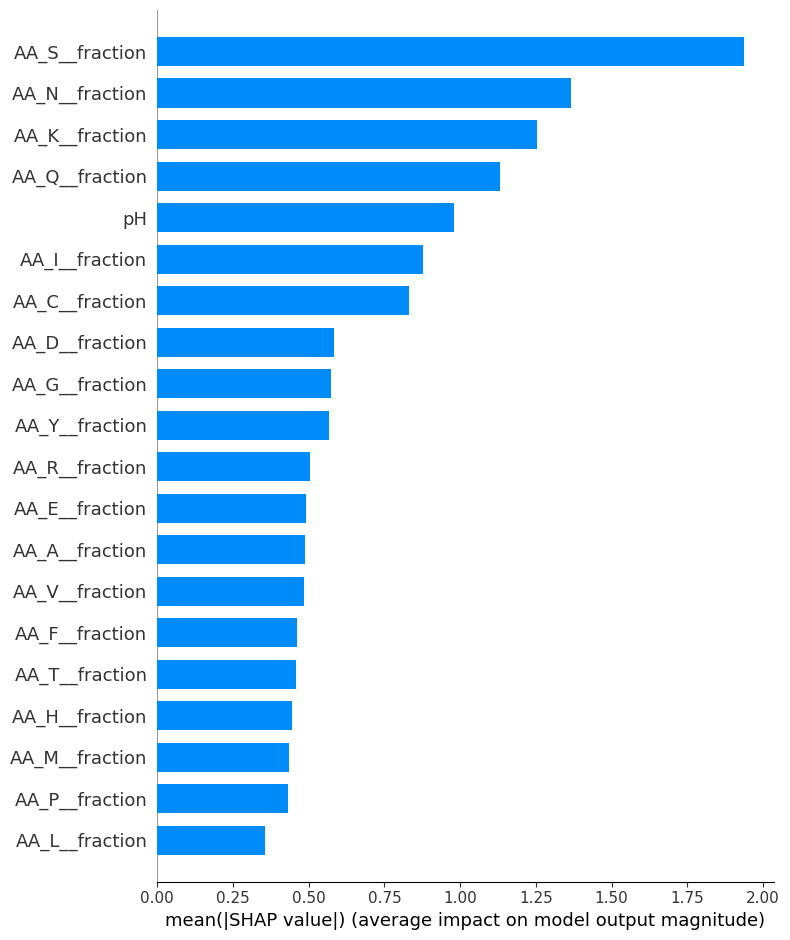

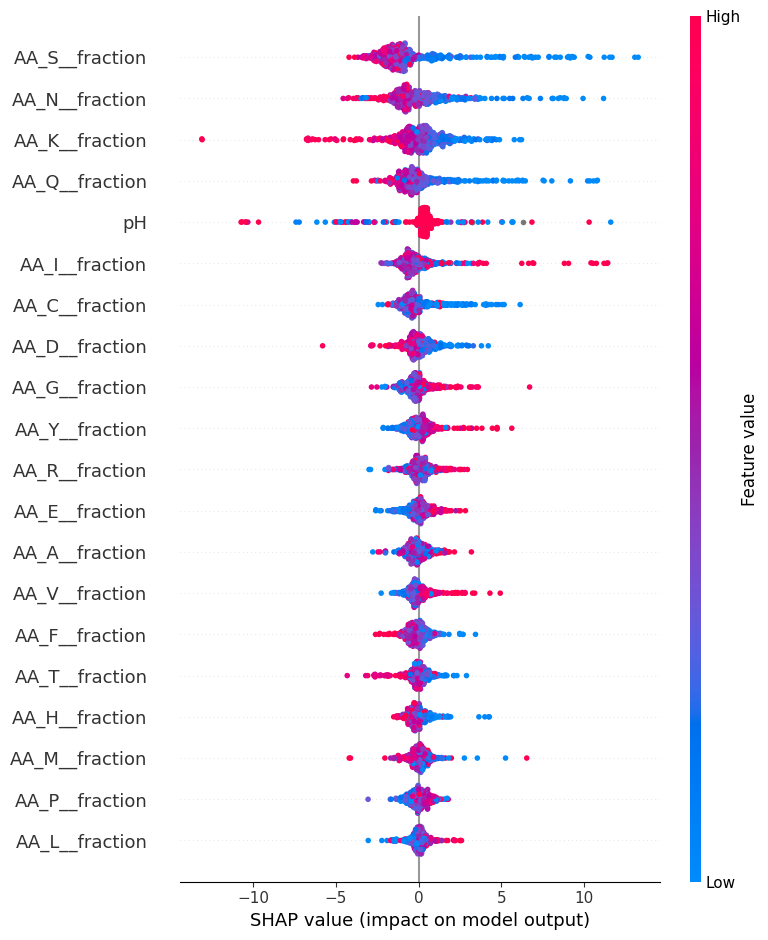

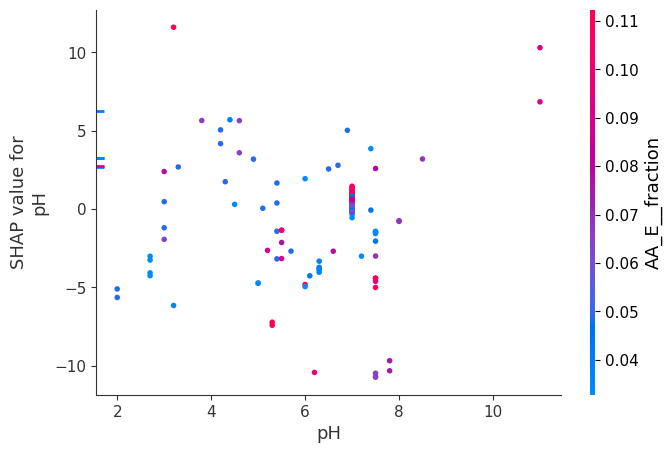

In [18]:
# --------------------  --------------------
import shap

print("\nInitializing SHAP Explainer...\n")

# Sample data for faster computation
X_sample = train_df[feature_cols].sample(500, random_state=42)

# Create SHAP Explainer
explainer = shap.Explainer(baseline_model, X_sample)

# Calculate SHAP values
shap_values = explainer(X_sample)

# ---- Global Feature Importance ----
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# ---- Beeswarm Plot ----
shap.summary_plot(shap_values, X_sample)

# ---- Dependence Plot for pH ----
shap.dependence_plot("pH", shap_values.values, X_sample)

# ---- Local Explanation for First Instance ----
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], X_sample.iloc[0])


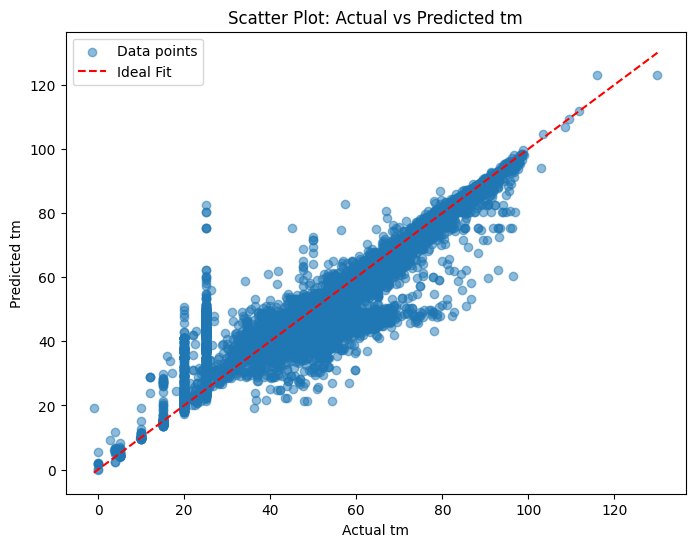

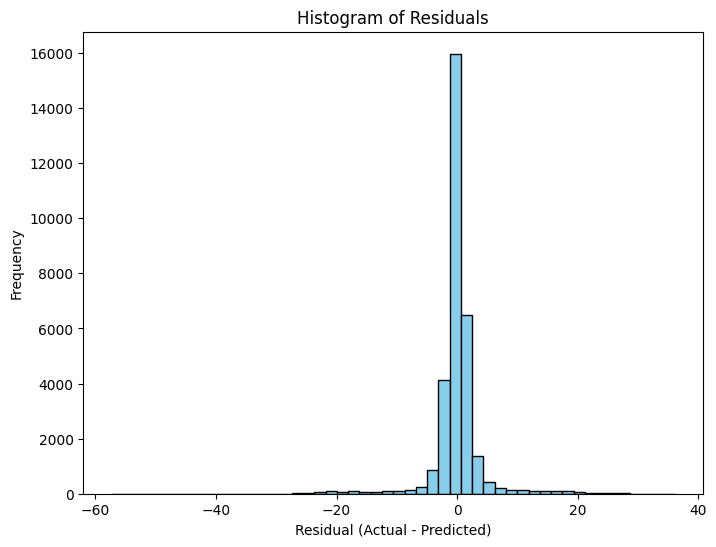

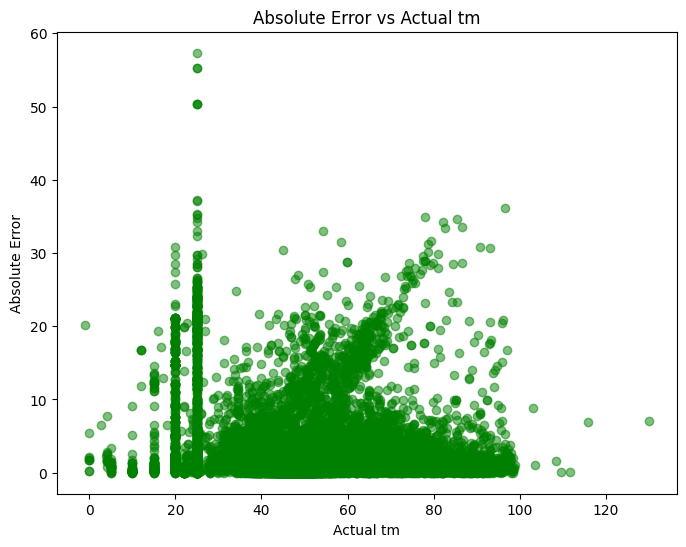

Mean Absolute Error (Training): 1.988


In [20]:
# Compute in-sample predictions on the training set for error analysis
train_preds = baseline_model.predict(train_df[feature_cols].to_numpy())
residuals = train_df["tm"].values - train_preds  # error: actual - predicted

# 1. Scatter Plot: Actual vs Predicted tm
plt.figure(figsize=(8,6))
plt.scatter(train_df["tm"], train_preds, alpha=0.5, label='Data points')
plt.plot([train_df["tm"].min(), train_df["tm"].max()],
         [train_df["tm"].min(), train_df["tm"].max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Actual tm")
plt.ylabel("Predicted tm")
plt.title("Scatter Plot: Actual vs Predicted tm")
plt.legend()
plt.show()

# 2. Histogram of Residuals
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# 3. Scatter Plot: Absolute Error vs Actual tm
abs_error = np.abs(residuals)
plt.figure(figsize=(8,6))
plt.scatter(train_df["tm"], abs_error, alpha=0.5, color='green')
plt.xlabel("Actual tm")
plt.ylabel("Absolute Error")
plt.title("Absolute Error vs Actual tm")
plt.show()

# Print overall error metric for reference
mae = np.mean(abs_error)
print("Mean Absolute Error (Training): {:.3f}".format(mae))
